In [314]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [315]:
df = pd.read_csv('WA_Marketing-Campaign.csv')

In [357]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [316]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [318]:
df.groupby('Promotion').agg({'SalesInThousands': [np.mean, np.median, min, max]})

SalesInThousands                      
                      mean  median    min    max
Promotion                                       
1                58.099012  55.385  30.81  99.65
2                47.329415  45.385  17.34  88.64
3                55.364468  51.165  22.18  96.48

Text(0.5, 1.0, 'Revenue of Different Promotions')

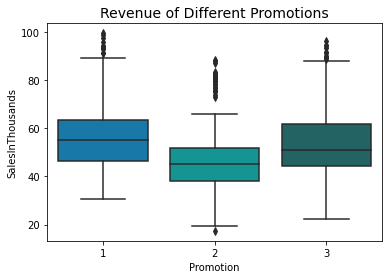

In [319]:
sns.boxplot(data=df, x='Promotion', y='SalesInThousands', palette="winter_d")
plt.title('Revenue of Different Promotions', fontsize=14)

Text(0.5, 1.0, 'Revenue of Different Promotions by weeks')

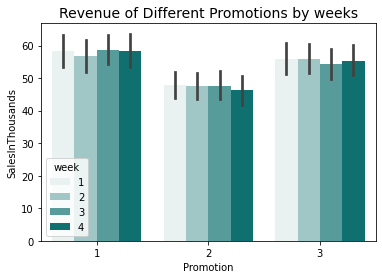

In [320]:
sns.barplot(data=df, x='Promotion', y='SalesInThousands', hue='week', color='teal')
plt.title('Revenue of Different Promotions by weeks', fontsize=14)

→ У 1 и 3 рекламных групп средние продажи выше, чем у 2. При этом, они практически не варьируются от недели к неделе.

In [321]:
percent_of_sales = df.groupby('Promotion', as_index=True) \
.agg({'SalesInThousands':'sum'})['SalesInThousands'].transform(lambda x: x/x.sum())

Text(0.5, 1.0, 'Distribution of Promotions')

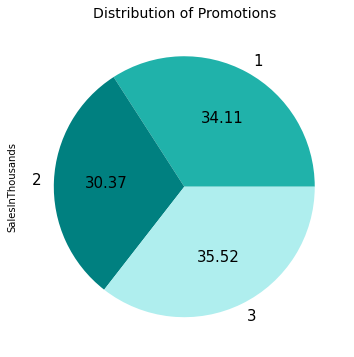

In [322]:
percent_of_sales.plot.pie(labels=[1, 2, 3],
    colors=["lightseagreen", "teal", "paleturquoise"],
    autopct="%.2f",
    fontsize=15,
    figsize=(6, 6))
plt.title('Distribution of Promotions', fontsize=14)

→ Как видно из графика, каждая рекламная группа занимает примерно треть от всего объема продаж. Тем не менее, рекламная группа 3 имеется наибольшую долю продаж - почти 36%.

Посмотрим на размер точек продаж в каждой из групп.

In [323]:
marketsize_by_promotion = df.groupby(['Promotion', 'MarketSize'], as_index=False).agg({'MarketID':'count'})

Text(0.5, 1.0, 'Number of Promotions by Market Sizes')

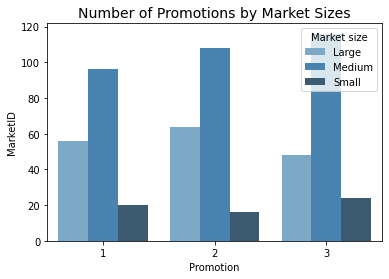

In [324]:
sns.barplot(data=marketsize_by_promotion, x='Promotion', y='MarketID', hue='MarketSize', palette="Blues_d")
plt.legend(title='Market size')
plt.title('Number of Promotions by Market Sizes', fontsize=14)

→ Рестораны среднего размера составляют наибольшую часть в каждой из рекламных групп, а рестораны малого размера - наименьшую.

In [325]:
df.groupby('Promotion').agg({'AgeOfStore':[np.mean, min, max]})

AgeOfStore        
                mean min max
Promotion                   
1           8.279070   1  27
2           7.978723   1  28
3           9.234043   1  24

→ При этом, для каждой рекламной группы средний возраст ресторана примерно равен.

Таким образом, различные показатели рекламных групп существенно не различаются между собой. Выборочные группы схожи, а, значит, результаты A/B теста продемонстрируют реальное влияние каждой из рекламных кампаний на продажи.

Проверим, являются ли статзначимыми различия между рекламными группами.

In [326]:
promotion_1 = df.loc[df['Promotion']==1]
promotion_1.shape

(172, 7)

In [327]:
promotion_2 = df.loc[df['Promotion']==2]
promotion_2.shape

(188, 7)

In [328]:
promotion_3 = df.loc[df['Promotion']==3]
promotion_3.shape

(188, 7)

In [329]:
stats.shapiro(promotion_1['SalesInThousands'])

ShapiroResult(statistic=0.9153000712394714, pvalue=1.9773297665892642e-08)

Text(0.5, 1.0, 'Distribution of Revenue in 1 Promotion')

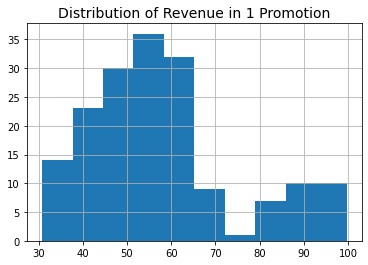

In [356]:
promotion_1['SalesInThousands'].hist()
plt.title('Distribution of Revenue in 1 Promotion', fontsize=14)

In [331]:
stats.shapiro(promotion_2['SalesInThousands'])

ShapiroResult(statistic=0.9145088791847229, pvalue=5.456262108793908e-09)

Text(0.5, 1.0, 'Distribution of Revenue in 2 Promotion')

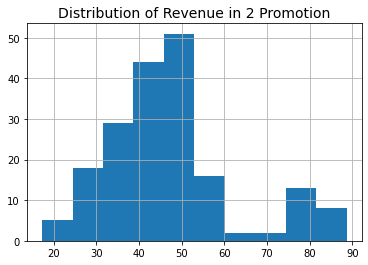

In [355]:
promotion_2['SalesInThousands'].hist()
plt.title('Distribution of Revenue in 2 Promotion', fontsize=14)

In [333]:
stats.shapiro(promotion_3['SalesInThousands'])

ShapiroResult(statistic=0.9207685589790344, pvalue=1.499518376135711e-08)

Text(0.5, 1.0, 'Distribution of Revenue in 3 Promotion')

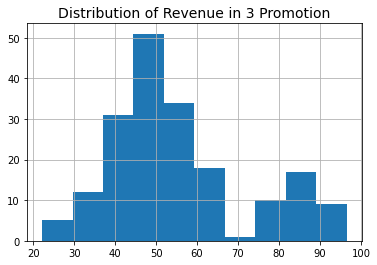

In [354]:
promotion_3['SalesInThousands'].hist()
plt.title('Distribution of Revenue in 3 Promotion', fontsize=14)

→ Для всех трех выборок отклоняем гипотезу о нормальности распределения.

In [335]:
stats.levene(promotion_1['SalesInThousands'], promotion_2['SalesInThousands'], promotion_3['SalesInThousands'])

LeveneResult(statistic=1.2696787527507418, pvalue=0.2817514565692118)

→ Дисперсии внутри групп равны.

In [337]:
stats.f_oneway(promotion_1['SalesInThousands'], promotion_2['SalesInThousands'], promotion_3['SalesInThousands'])

F_onewayResult(statistic=21.953485793080677, pvalue=6.765849261408714e-10)

→ Результаты теста ANOVA показывают значительные различия между рекламными группами.

In [338]:
tukey = pairwise_tukeyhsd(endog=df['SalesInThousands'], groups=df['Promotion'], alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-10.7696,0.001,-14.774,-6.7652,True
1,3,-2.7345,0.2447,-6.7389,1.2698,False
2,3,8.0351,0.001,4.1207,11.9494,True


Text(0, 0.5, 'Sales')

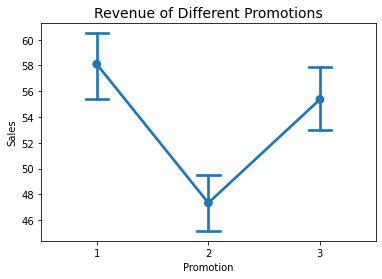

In [351]:
sns.pointplot(x = 'Promotion', y = 'SalesInThousands', data = df, capsize = .2)
plt.title('Revenue of Different Promotions', fontsize=14)
plt.xlabel('Promotion')
plt.ylabel('Sales')

→ Тест Тьюки показывает, что существует значительная разница между рекламной группой 2 и остальными. Между 1 и 3 рекламными группами разницы нет.

Затем посмотрим, есть ли влияние размера точек продаж на доходы.

In [340]:
formula = "SalesInThousands ~ Promotion + MarketSize + Promotion:MarketSize"
model = ols(formula, df).fit()
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
MarketSize,75783.881130,2.0,266.355823,2.714481e-81
Promotion,49.337378,1.0,0.346810,5.561699e-01
Promotion:MarketSize,135.749207,2.0,0.477115,6.208318e-01
Residual,77105.248050,542.0,NaN,NaN


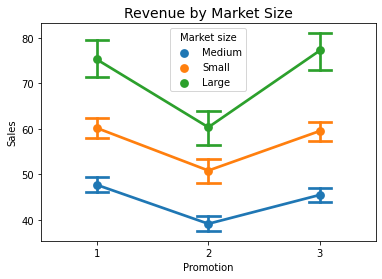

In [353]:
sns.pointplot(x = 'Promotion', y = 'SalesInThousands', hue = 'MarketSize', data = df, capsize = .2)
plt.title('Revenue by Market Size', fontsize=14)
plt.xlabel('Promotion')
plt.ylabel('Sales')
plt.legend(title = 'Market size')

→ Размер ресторана, а также взаимодействие размера ресторана и рекламной группы значимо влияют на продажи.

In [343]:
small_market = df.loc[df['MarketSize']=='Small']

In [344]:
tukey = pairwise_tukeyhsd(endog=small_market['SalesInThousands'], groups=small_market['Promotion'], alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-9.3519,0.001,-13.6829,-5.0208,True
1,3,-0.6483,0.9,-4.5579,3.2612,False
2,3,8.7035,0.001,4.536,12.8711,True


In [345]:
medium_market = df.loc[df['MarketSize']=='Medium']

In [346]:
tukey = pairwise_tukeyhsd(endog=medium_market['SalesInThousands'], groups=medium_market['Promotion'], alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-8.5583,0.001,-11.3108,-5.8057,True
1,3,-2.2037,0.1356,-4.9113,0.5038,False
2,3,6.3545,0.001,3.7306,8.9785,True


In [347]:
large_market = df.loc[df['MarketSize']=='Large']

In [348]:
tukey = pairwise_tukeyhsd(endog=large_market['SalesInThousands'], groups=large_market['Promotion'], alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-14.9139,0.001,-21.5284,-8.2993,True
1,3,1.9681,0.7701,-5.1424,9.0785,False
2,3,16.8819,0.001,9.9797,23.7842,True


→ При этом результаты теста Тьюки для точек продаж малого, среднего и большого размеров такие же, как и для общего анализа.

Таким образом, компании следует остановиться на рекламных кампаниях 1 и 3 и продолжить их использовать в своих будущих маркетинговых программах, независимо от того, на какого размера рынок будет направлена реклама.